## Assignment 4 Group no. 7

### Project members
Linn Karlsson, linn.karlsson@aces.su.se

### Short description of notebook
This notebook contains functions for reading my data and evaluating the performance of the gradient boosting classifier (5-fold cross validation with various performance metrics and feature importances). I explore and visualise the laboratory data to select features to use for classification. I train a baseline model and then employ hyperparameter tuning and compare the two.

## Import packages

In [1]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_score, roc_auc_score
import scipy.cluster.hierarchy as shc

## Functions

### Functions from previous assignments (sort of)

This was a function I wrote during the assignments just to double check that my submitted AUC function was working correctly. It is basically just a wrapper around the sklearn AUC function that formats the true labels in a way that the function can handle a multi-class case.

In [2]:
def sklearn_auc(predictions, test_labels):
    # Copy predictions to get df with same shape
    true = predictions.copy()
    # First fill it with zeros
    true[:] = 0
    # Then go through the correct labels and put 1's in the corresponding df row
    for i, label in test_labels.items():
        true.loc[i, label] = 1
    # Return the sklearn AUC score
    return roc_auc_score(true, predictions, average='weighted')

### Other functions

In [54]:
def read_MBS(path, redo_subtraction=True):
    '''Function to read data from the MBS instrument and redo background subtraction (if using array features).
    Also drops some columns that are not really features (e.g. timestamp)'''
    # List of data files
    flist = glob.glob(path+'*.csv')
    flist.sort()
    
    # Empty list to hold files
    data = []
    # Shape columns, needed for background addition and subtraction
    shape = ['CA1_{}'.format(i) for i in range(512)] + ['CA2_{}'.format(i) for i in range(512)]

    for i, f in enumerate(flist):
        df = pd.read_csv(f, skiprows=30)
        # Pick out aerosol type from file name and add label
        df['label'] = f.split('_')[1]
        if redo_subtraction:
            # Reinsert the background subtraction made by the instrument
            df.loc[df['FT'] == 0, shape] = df.loc[df['FT'] == 0, shape] + np.floor(np.mean(df.loc[df['FT'] == 1, shape]))
        # Append to list
        data.append(df)

    # Combine dataframes
    data = pd.concat(data)
    data.reset_index(inplace=True, drop=True)
    
    # Drop non-feature columns and unused columns
    data.drop(columns=['Time(ms)', 'LASER', 'MPC', 'Total', 'Measured', 'FlrRatio'], inplace=True)
    
    return data


def fivefoldcrossval(X, y, plot=False, return_model=False, **kwargs):
    '''Function to do five-fold cross-validation on data X and labels y, 
    using a default GradientBoostingClassifier from sklearn. 4:1 train:test ratio. 
    Input:
        X : pandas dataframe of samples, features as columns
        y : pandas series of correct class labels
    Prints average scores (accuracies, AUC, ...) across the five folds, and prints feature importances. 
    '''
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    accs = []
    baccs = []
    precs = pd.DataFrame(index=range(5), columns=np.sort(y.unique()))
    aucs = []
    
    cms = []
    
    i = 0

    for train_index, test_index in tqdm(sss.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = GradientBoostingClassifier(random_state=0, **kwargs)
        model.fit(X_train, y_train)

        accs.append(model.score(X_test, y_test))
        
        prediction = model.predict(X_test)
        pred_probs = pd.DataFrame(model.predict_proba(X_test), index=y_test.index, columns=model.classes_)
        
        aucs.append(sklearn_auc(pred_probs, y_test))
        baccs.append(balanced_accuracy_score(prediction, y_test))
        precs.loc[i, :] = precision_score(prediction, y_test, average=None)
        i += 1
        
        cms.append(pd.DataFrame(confusion_matrix(prediction, y_test),
                                columns=model.classes_, index=model.classes_))

    print('Average performance metrics:')
    print('Accuracy: ', np.round(100*np.mean(np.array(accs)), 2), '%')
    print('Balanced accuracy: ', np.round(100*np.mean(np.array(baccs)), 2), '%')
    print('Precision: ')
    display(precs.mean(axis=0))
    print('AUC: ', np.mean(aucs))
    print('Confusion matrix (sum):')
    display(sum(cms))
    model = GradientBoostingClassifier(random_state=0, **kwargs)
    model.fit(X, y)
    print('Feature importances:')
    importances = pd.Series(model.feature_importances_, index=X_train.columns)
    if plot:
        importances.sort_values(ascending=False).plot(kind='bar')
        plt.ylabel('Feature Importance Score')
    else:
        print('Fluorescence:\t', np.round(100*np.sum(importances[fluor]), 2), '%')
        print('Size:\t\t', np.round(100*importances['Size'], 2), '%')
        print('TOF:\t\t', np.round(100*importances['TOF'], 2), '%')
        print('Shape:\t\t', np.round(100*np.sum(importances.drop(fluor+['Size', 'TOF'])), 2), '%, ({} shape features)'.format(len(importances.index.drop(fluor+['Size', 'TOF']))))
    
    if return_model:
        return model
    
    
def fivefold_score(X, y, **kwargs):
    '''Function to print ROC AUC scores for five-fold cross validation.
    Input:
        X : pandas dataframe of samples, features as columns
        y : pandas series of correct class labels
    Prints AUC mean and std across the five folds. Using this for parameter tuning...'''
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    aucs = []

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = GradientBoostingClassifier(random_state=0, **kwargs)
        model.fit(X_train, y_train)

        pred_probs = pd.DataFrame(model.predict_proba(X_test), index=y_test.index, columns=model.classes_)
        aucs.append(sklearn_auc(pred_probs, y_test))

    return [np.round(np.mean(aucs), 4), np.round(np.std(aucs), 4)]




## Read and preprocess data 

### Read data

In [4]:
data = read_MBS('./data/', redo_subtraction=True)

### Redo the background subtraction

The instrument automatically makes a background subtraction for the shape measurements. It does this once per data file. Since each data file contains a different type of particle, this means that particles of the same type will have the same background subtraction. This, in turn, leads to 'overfitting' where the model can accurately distinguish between particle types, but not because of any real particle features but rather because of the "background signal" in shape channels that are mostly noise (Simon Ruske, personal communication). Thus, we have to reinsert the instrument's background subtraction (done in the function above), and then make a new one using the average background measurement across all data files.

#### Check if this makes sense to do (ie, if the FT measurements are relatively similar across the files)


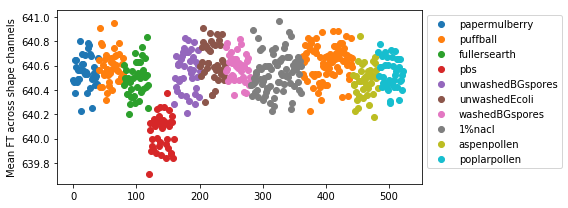

In [5]:
# (I average all the 1024 channels, not sure how else to represent them...)
shape = ['CA1_{}'.format(i) for i in range(512)] + ['CA2_{}'.format(i) for i in range(512)]
background = data.loc[data['FT']==1, shape].mean(axis=1).reset_index(drop=True)
# Want to know which data are from which file
names = data.loc[data['FT']==1, 'label'].reset_index(drop=True)

plt.figure(figsize=(8, 3))
for name in names.unique():
    plt.scatter(background[names == name].index, background[names == name].values, label=name)
plt.legend(bbox_to_anchor=[1, 1])

plt.ylabel('Mean FT across shape channels')
plt.tight_layout()
plt.show()

The pbs sample seems to have a different FT background than the other files. The difference is small, but including it for the average FT measurements across all files for the background subtraction could potentially introduce a bias. 

&rarr; I will remove the pbs data for the time being. If I don't use them they could actually be used as a test at the end, to see if particles with a different background subtraction can still be classified with any accuracy (pbs should be similar enough to NaCl for this comparison to make sense).

In [6]:
# Remove pbs
print('Removing {} pbs samples'.format(len(data[data.label=='pbs'])))
data = data[data.label != 'pbs']

Removing 1428 pbs samples


In [7]:
# Do new background subtraction using FT measurements from all files
data.loc[data['FT'] == 0, shape] = data.loc[data['FT'] == 0, shape] - np.floor(np.mean(data.loc[data['FT'] == 1, shape]))

### Divide data into training, test, and calibration sets

#### Pick out non-background data and make some column groups

In [8]:
# Drop forced trigger measurements (blanks)
data = data[data.FT == 0]
data.drop(columns=['FT'], inplace=True)

shape = ['CA1_{}'.format(i) for i in range(512)] + ['CA2_{}'.format(i) for i in range(512)]
fluor = ['XE1_{}'.format(i+1) for i in range(8)]
other = ['Size', 'TOF', 'label']
stats = data.columns.drop(shape+fluor+other)

In [9]:
# Original data
data_all = data.copy()

In [10]:
# Separate data from labels
labels = data['label']
data = data_all.drop(columns=['label']+list(stats))

Ruske et al. (2017) used the full shape measurements (1024) and not the statistics calculated from them (22), which is why I drop the stats above. However, I will most likely try and see what happens if I use the stats instead at a later stage...    

#### Split data into training, calibration, and test sets
50% training <br>
25% calibration <br>
25% test

In [11]:
# First split into training (50% of total data) and test (25% of total data) sets
data_train, data_test, labels_train, labels_test = train_test_split(data, labels,
                                                                    test_size=0.25,
                                                                    train_size=0.5,
                                                                    stratify=labels,
                                                                    shuffle=True,
                                                                    random_state=0)
# The above used only 75% of the data.
# The remaining 25% is also stratified and will be used as the calibration set.
idx_cal = data.index ^ data_train.index ^ data_test.index
idx_cal = np.random.permutation(idx_cal)
data_cal, labels_cal = data.loc[idx_cal], labels.loc[idx_cal]

### Can I replicate the results from Ruske et al. (2017)?


In [12]:
# Broad class labels used by Ruske et al. (2017)
alt_labels = {'1%nacl': 'non-bio', 'fullersearth': 'non-bio', 'pbs': 'non-bio', 'puffball': 'fungal',
              'unwashedEcoli': 'bacteria', 'unwashedBGspores': 'bacteria', 'washedBGspores': 'bacteria',
              'papermulberry': 'pollen', 'poplarpollen': 'pollen', 'aspenpollen': 'pollen'}


Non-biological: 1%NaCl, Fuller's earth dust, Phosphate buffered saline (pbs; **removed here**) <br>
Pollen: Paper mulberry, Poplar, Aspen <br>
Bacteria: Unwashed E. coli., Unwashed BG spores, Washed BG spores <br>
Fungal spores: Puffball

#### 5-fold cross-validation using stratified splits

In [13]:
X = data_train.copy()
y = labels_train.replace(alt_labels)

fivefoldcrossval(X, y)

5it [06:46, 81.43s/it]

Average performance metrics:
Accuracy:  81.14 %
Balanced accuracy:  83.14 %
Precision: 


bacteria    0.887023
fungal      0.369349
non-bio     0.937984
pollen      0.698990
dtype: float64

AUC:  0.9374733471690113
Confusion matrix (sum):


,bacteria,fungal,non-bio,pollen
bacteria,2324,43,90,32
fungal,15,482,115,38
non-bio,268,755,3630,228
pollen,13,25,35,692


Feature importances:
Fluorescence:	 58.8 %
Size:		 1.92 %
TOF:		 13.11 %
Shape:		 26.18 %, (1024 shape features)


Ruske et al. (2017) reported 82.8% accuracy, I get 81.1%. Given that I have excluded the pbs data (1428 samples) and only use half of the remaining samples as training data, I think the difference is small enough to be considered as matching their results.

## Feature selection

In [14]:
data_train.shape

(8784, 1034)

We have a large number of features (1034) compared to the number of samples (8784). Reducing the dimensionality is probably a good idea here! The shape parameters make up 1024 of the features, so they are the best place to start looking...

### Look at the shape features of the training data

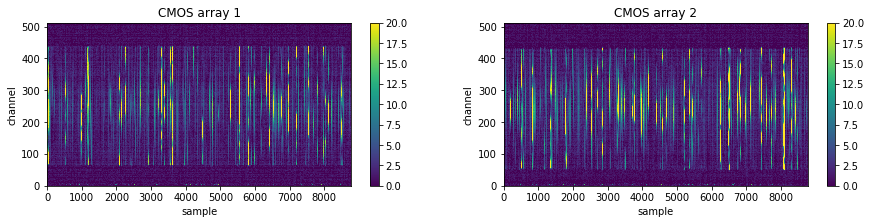

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

im0 = ax[0].pcolormesh(data_train[shape[:512]].T, vmin=0, vmax=20)
plt.colorbar(im0, ax=ax[0])
ax[0].set_title('CMOS array 1')
ax[0].set_ylabel('channel')
ax[0].set_xlabel('sample')

im1 = ax[1].pcolormesh(data_train[shape[512:]].T, vmin=0, vmax=20)
plt.colorbar(im1, ax=ax[1])
ax[1].set_title('CMOS array 2')
ax[1].set_ylabel('channel')
ax[1].set_xlabel('sample')

plt.show()

Capped colourbar at 20 au because I am most interested in the noise. <br>
* It is immediately obvious that some channels are just noise and not actual data
* The noise channels are not exactly the same for the two arrays, i.e. the arrays are aligned differently

Questions arise: <br>
1. Should the channels be removed, and if so which ones?<br>
2. Would the redoing of the background subtraction (above) still be necessary if the channels were removed? <br>
3. The array alignment is unlikely to be exactly the same for different instruments -- how to deal with this?

#### 1. Identifying which channels to remove

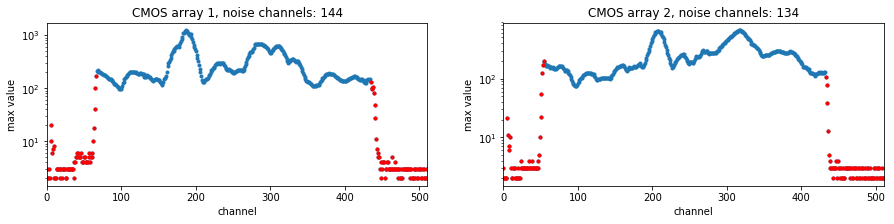

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

# # FIRST ARRAY (max values)
cmos1 = data_train[shape[:512]].max().reset_index(drop=True)
cmos1.plot(style='.', logy=True, ax=ax[0])
# Identifying channels to drop from plot (tweaking the numbers until it looks alright)
ch_1 = np.arange(len(cmos1))
l_drop1 = (ch_1 < 70) & (cmos1 < 200)
r_drop1 = (ch_1 > 434) & (cmos1 < 200)

cmos1.iloc[(l_drop1 | r_drop1).values].plot(style='.', color='red', ax=ax[0])

cmos1_drop = np.array(shape[:512])[(l_drop1 | r_drop1).values]

ax[0].set_title('CMOS array 1, noise channels: {}'.format(len(cmos1_drop)))
ax[0].set_ylabel('max value')
ax[0].set_xlabel('channel')

# # SECOND ARRAY (max values)
cmos2 = data_train[shape[512:]].max().reset_index(drop=True)
cmos2.plot(style='.', logy=True, ax=ax[1])
# Identifying channels to drop from plot
ch_2 = np.arange(len(cmos2))
l_drop2 = (ch_2 < 55) & (cmos2 < 200)
r_drop2 = (ch_2 > 432) & (cmos2 < 200)

cmos2.iloc[(l_drop2 | r_drop2).values].plot(style='.', color='red', ax=ax[1])

cmos2_drop = np.array(shape[512:])[(l_drop2 | r_drop2).values]

ax[1].set_title('CMOS array 2, noise channels: {}'.format(len(cmos2_drop)))
ax[1].set_ylabel('max value')
ax[1].set_xlabel('channel')

plt.show()

I have tried to remove too much rather than too little, in the hopes that applying this "filter" to data from other instruments will remove most of the noise there also... 

##### Does removing them make a difference in the model's accuracy?

In [17]:
# Drop the noise channels in the data before learning the model
X = data_train.drop(columns=list(cmos1_drop)+list(cmos2_drop))
y = labels_train.replace(alt_labels)

fivefoldcrossval(X, y)

5it [04:53, 58.77s/it]

Average performance metrics:
Accuracy:  79.76 %
Balanced accuracy:  80.82 %
Precision: 


bacteria    0.888550
fungal      0.301916
non-bio     0.935142
pollen      0.672727
dtype: float64

AUC:  0.9297719784038018
Confusion matrix (sum):


,bacteria,fungal,non-bio,pollen
bacteria,2328,39,95,35
fungal,8,394,124,50
non-bio,269,833,3619,239
pollen,15,39,32,666


Feature importances:
Fluorescence:	 60.23 %
Size:		 2.58 %
TOF:		 13.18 %
Shape:		 24.0 %, (746 shape features)


The accuracy dropped by ~1.4 %. This is not a lot, and it is easier to justify removing the noise than it is to keep it. 

&rarr; Remove noise channels

#### 2. Does removing the noise channels make redoing the background subtraction unnecessary?

In [18]:
# Re-read data, but don't undo the background subtraction made by the instrument
data_new = read_MBS('./data/', redo_subtraction=False)

# Drop pbs to make comparison fair since I dropped that before
data_new = data_new[data_new.label != 'pbs']

# Drop forced trigger measurements (blanks)
data_new = data_new[data_new.FT == 0]

# Separate data from labels
labels_new = data_new['label']
data_new = data_new.drop(columns=['label']+list(stats))

##### Re-do split into training and test

In [19]:
# Split into training (50% of total new) and test (25% of total new) sets
new_train, new_test, labels_new_train, labels_new_test = train_test_split(data_new, labels_new,
                                                                          test_size=0.25,
                                                                          train_size=0.5,
                                                                          stratify=labels_new,
                                                                          shuffle=True,
                                                                          random_state=0)

##### 5-fold cross-validation using stratified splits

In [20]:
# Drop the noise channels in the data before learning the model
X = new_train.drop(columns=list(cmos1_drop)+list(cmos2_drop))
y = labels_new_train.replace(alt_labels)

fivefoldcrossval(X, y)

5it [05:15, 63.26s/it]

Average performance metrics:
Accuracy:  95.95 %
Balanced accuracy:  96.06 %
Precision: 


bacteria    0.980534
fungal      0.904981
non-bio     0.989922
pollen      0.856566
dtype: float64

AUC:  0.997616607140794
Confusion matrix (sum):


,bacteria,fungal,non-bio,pollen
bacteria,2569,6,5,25
fungal,10,1181,19,17
non-bio,31,98,3831,100
pollen,10,20,15,848


Feature importances:
Fluorescence:	 37.54 %
Size:		 0.72 %
TOF:		 7.81 %
Shape:		 53.93 %, (747 shape features)


Despite having reduced the number of features and removed all the channels that are definitely only noise, the accuracy is still way too high compared to that of the data with the redone background subtraction (see above). The shape parameters also carry most of the weight, which is another indication that the issue is still there.

&rarr; Simply removing the noise channels is not enough to avoid the "overfitting" problem

#### 3. The issue of array alignment of different MBS instruments 

##### Read other data from our MBS instrument (different from Ruske et al., 2017)

In [21]:
otherdata = pd.read_csv('/home/linn/PhD/projects/MBS/data/ACES_lab_Jan2018_0000_0008.csv', skiprows=32)

otherdata = otherdata.loc[otherdata.FT == 0, shape].max().reset_index(drop=True)

##### Plot the maximum shape channel values, and colour the noise channels from the OTHER instrument

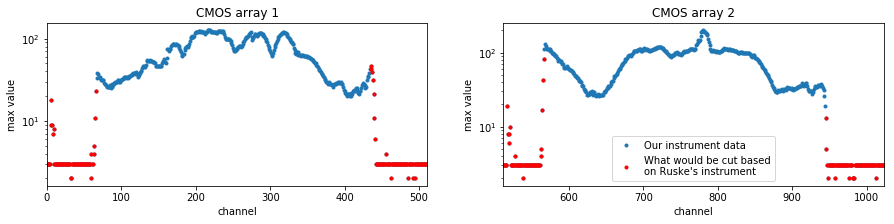

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

otherdata.iloc[:512].plot(style='.', logy=True, ax=ax[0], label='Our instrument data')
otherdata.iloc[:512].iloc[(l_drop1 | r_drop1).values].plot(style='.', color='red', ax=ax[0],
                                                           label="What would be cut based\non Ruske's instrument")

ax[0].set_title('CMOS array 1')
ax[0].set_ylabel('max value')
ax[0].set_xlabel('channel')

otherdata.iloc[512:].plot(style='.', logy=True, ax=ax[1], label='Our instrument data')
otherdata.iloc[512:].iloc[(l_drop2 | r_drop2).values].plot(style='.', color='red', ax=ax[1],
                                                           label="What would be cut based\non Ruske's instrument")

ax[1].set_title('CMOS array 2')
ax[1].set_ylabel('max value')
ax[1].set_xlabel('channel')
ax[1].legend()

plt.show()

The alignment seems to be similar, but not exactly the same. This suggests that removing the noise features from the model training is not completely straight-forward. Does an array pixel position in one instrument correspond to the same position in another instrument? What does this mean for training the model? Presumably a different alignment would affect how a particle is classified. I guess many things come into play here, such as the orientation and position of the particles as they pass through the instrument, et cetera. It is far beyond the scope of this project to investigate this in depth.

A possible solution would be to be a bit more aggressive in how many features are removed, for example removing 80 channels from each edge for each array, and then binning or smoothing the remaining features to help reduce the effect of potential misalignment. I do not know if this would be enough, though...

In [23]:
# Bin shape columns
bins = np.arange(0, 512, 4)
groups = np.sort(np.concatenate([bins, bins, bins, bins]))

CA1 = data_train.loc[:, 'CA1_0':'CA1_511'].T.groupby(groups).mean().T
CA1.columns = ['CA1_b{}'.format(i) for i in range(len(bins))]
CA2 = data_train.loc[:, 'CA2_0':'CA2_511'].T.groupby(groups).mean().T
CA2.columns = ['CA2_b{}'.format(i) for i in range(len(bins))]

newdata = pd.concat([CA1, CA2, data_train[fluor+['Size', 'TOF']]], axis=1)

In [24]:
# Remove 20 bins from each edge of each array
to_remove = ['CA1_b{}'.format(i) for i in range(20)] \
            + ['CA1_b{}'.format(i) for i in range(128-20, 128)] \
            + ['CA2_b{}'.format(i) for i in range(20)] \
            + ['CA2_b{}'.format(i) for i in range(128-20, 128)]

newdata = newdata.drop(columns=to_remove)

In [25]:
X = newdata.copy()
y = labels_train.replace(alt_labels)

fivefoldcrossval(X, y)


5it [01:18, 15.75s/it]

Average performance metrics:
Accuracy:  78.55 %
Balanced accuracy:  77.87 %
Precision: 


bacteria    0.891221
fungal      0.278161
non-bio     0.922222
pollen      0.640404
dtype: float64

AUC:  0.924166090922004
Confusion matrix (sum):


,bacteria,fungal,non-bio,pollen
bacteria,2335,42,116,33
fungal,8,363,137,68
non-bio,267,833,3569,255
pollen,10,67,48,634


Feature importances:
Fluorescence:	 61.45 %
Size:		 2.92 %
TOF:		 13.67 %
Shape:		 21.95 %, (176 shape features)


Cutting a fixed number of channels and then binning the shape data reduced the accuracy by ~1.2% compared to just removing the noise channels and not binning. Further tests would be needed to see if this difference is significant, but at least the approach seems viable.

One question remains, however, and this is something I will test. Is there something that is more robust than using the acutal array pixels? The instrument does calculate a range of statistics from the array signals. The question is how robust these are to noise and the background subtraction issue.

#### Bonus question: Are the shape statistics more robust?

The shape statistics are calculated for both CMOS arrays (left and right). They include peak values, mean values, peak-to-mean ratio, and various standard statistics such as variance. They also include measures of asymmetry, i.e. how similar the left and right array are.

In [26]:
print(list(stats))

['SumL', 'SumR', 'PeakL', 'PeakR', 'MeanL', 'MeanR', 'PeakMeanL', 'PeakMeanR', 'VarianceL', 'VarianceR', 'SkewL', 'SkewR', 'KurtosisL', 'KurtosisR', 'PeakCountL', 'PeakCountR', 'PeakWidthL', 'PeakWidthR', 'MirrorL%', 'MirrorR%', 'AsymLR%', 'AsymLRinv%']


The calculation of these parameters treats the full shape data as two distributions (one per array), which makes sense because it uses the knowledge that the array data are a reduced image of a particle refraction pattern. Below, shape spectra are illustrated for two different particles. I show both raw data and binned data, and also data that have been smoothed using a 5-pixel rolling average because I think the software does that before calculating the statistics (the manual does not describe it in detail).

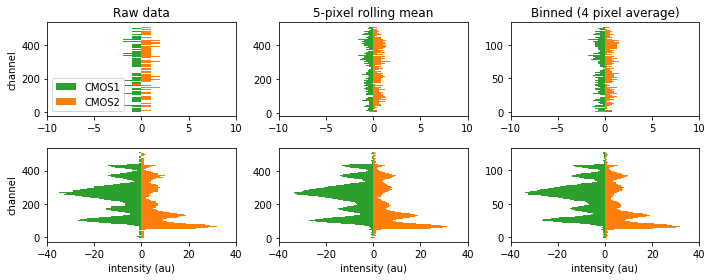

In [27]:
# Pick two particles
particle1 = data_train.loc[:, shape].iloc[1000, :]
particle2 = data_train.loc[:, shape].iloc[180, :]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 4), sharey='col', sharex='row')

# Raw
ax[0, 0].set_title('Raw data')
ax[0, 0].barh(np.arange(0, 512), -particle1.loc[:'CA1_511'],
           height=1, color='C2', label='CMOS1')
ax[0, 0].barh(np.arange(0, 512), particle1.loc['CA2_0':],
           height=1, color='C1', label='CMOS2')
ax[0, 0].set_xlim(-10, 10)
ax[0, 0].legend()

ax[1, 0].barh(np.arange(0, 512), -particle2.loc[:'CA1_511'],
           height=1, color='C2')
ax[1, 0].barh(np.arange(0, 512), particle2.loc['CA2_0':],
           height=1, color='C1')
ax[1, 0].set_xlim(-40, 40)

# 5-pixel rolling
ax[0, 1].set_title('5-pixel rolling mean')
ax[0, 1].barh(np.arange(0, 512), -particle1.loc[:'CA1_511'].rolling(5).mean(),
           height=1, color='C2', label='CMOS1')
ax[0, 1].barh(np.arange(0, 512), particle1.loc['CA2_0':].rolling(5).mean(),
           height=1, color='C1', label='CMOS2')

ax[1, 1].barh(np.arange(0, 512), -particle2.loc[:'CA1_511'].rolling(5).mean(),
           height=1, color='C2')
ax[1, 1].barh(np.arange(0, 512), particle2.loc['CA2_0':].rolling(5).mean(),
           height=1, color='C1')

# Binned
ax[0, 2].set_title('Binned (4 pixel average)')
bins = np.arange(0, 512, 4)
groups = np.sort(np.concatenate([bins, bins, bins, bins]))

CA1 = particle1.loc[:'CA1_511'].groupby(groups).mean()
CA2 = particle1.loc['CA2_0':].groupby(groups).mean()
ax[0, 2].barh(np.arange(0, len(CA1)), -CA1, height=1, color='C2')
ax[0, 2].barh(np.arange(0, len(CA1)), CA2, height=1, color='C1')

CA1 = particle2.loc[:'CA1_511'].groupby(groups).mean()
CA2 = particle2.loc['CA2_0':].groupby(groups).mean()
ax[1, 2].barh(np.arange(0, len(CA1)), -CA1, height=1, color='C2')
ax[1, 2].barh(np.arange(0, len(CA1)), CA2, height=1, color='C1')

for i in range(2):
    ax[i, 0].set_ylabel('channel')
    
for i in range(3):
    ax[1, i].set_xlabel('intensity (au)')

plt.tight_layout()
plt.show()

In [28]:
# Pick out features including the shape stats but not the full shape spectra
# I'll call it reduced dataset (rds)
labels_rds = data_all['label']
data_rds = data_all.drop(columns=['label']+list(shape))

In [29]:
# First split into training (50% of total data) and test (25% of total data) sets
rds_train, rds_test, labels_rds_train, labels_rds_test = train_test_split(data_rds, labels_rds,
                                                                          test_size=0.25,
                                                                          train_size=0.5,
                                                                          stratify=labels_rds,
                                                                          shuffle=True,
                                                                          random_state=0)

In [30]:
# Drop the noise channels in the data before learning the model
X = rds_train.copy()
y = labels_rds_train.replace(alt_labels)

fivefoldcrossval(X, y)

5it [00:22,  4.57s/it]

Average performance metrics:
Accuracy:  80.96 %
Balanced accuracy:  80.8 %
Precision: 


bacteria    0.883206
fungal      0.478161
non-bio     0.915245
pollen      0.638384
dtype: float64

AUC:  0.9342244970574045
Confusion matrix (sum):


,bacteria,fungal,non-bio,pollen
bacteria,2314,28,119,23
fungal,15,624,142,87
non-bio,278,595,3542,248
pollen,13,58,67,632


Feature importances:
Fluorescence:	 60.11 %
Size:		 2.54 %
TOF:		 12.3 %
Shape:		 25.05 %, (22 shape features)


Well, at least the calculated statistics give almost the same accuracy as the full shape features with the redone background subtraction. That would suggest that they are at least robust to that issue. The precision for the fungal spore class is higher than the method where I removed the noise channels. Not sure if this indicates there is still an issue, but I think there are many advantages of using the calculated statistics anyway...

&rarr; use stats instead of array pixels

### Conclusions/final thoughts on features

I trust that the array alignments have been calibrated correctly. However, it seems that there are still differences between individual arrays (both within one instrument and between different instruments). With the type of learning algorithm considered here, choices are made depending on each single feature. Thus, it only takes a shift of one pixel/channel between instruments for the model to no longer be generalisable to data collected with another instrument. All shape features together seem to make up around 20-25% of the classification decision, so it would be better if the model could be made more robust to the aforementioned CMOS array differences. Possible solutions: <br>
* A combination of removing noise channels and either
    - Smoothing or binning the shape data to make features comparable across MBS instruments, or
    - Post-processing the shape data and re-centering the arrays before training the model, such that re-centred shape output from another instrument would result in features being "the same"

* Using the shape statistics calculated by the instrument software, as these appear to be more robust to noise and would most likely also be more robust to array alignment differences. The instrument manual is brief, but it is possible that the data are smoothed (5-pixel rolling average is mentioned) before the statistics are calculated, which might explain why they are more robust.

* Using a different type of learning algorithm

I will use the calculated shape statistics, because those 22 features produce virutally the same accuracy as using all 1024 shape features, and also only marginally higher accuracy than all my attempts to reduce the full shape features (by removing noise, binning, etc), so I don't think they suffer from the background subtraction issue mentioned at the beginning of this notebook. They have the additional benefit that I can include the phosphate buffered saline samples.

The calculated statistics also provide something that the CMOS array data cannot -- the calculation of the statistics, and the decision of which statistics are relevant, requires some domain knowledge. That is, additional knowledge is introduced into the model by the use of the calculated statistics. The model could not deduce this knowledge on its own, since it considers each array pixel separately from all the others while they could in fact be considered as "units" of a whole (or two halves), something which the statistics reflect.

Another way to achieve this "extra knowledge" could perhaps be to represent the array data as a 2x512 image and instead use something like a convolutional neural network for the classification task.

## Training the model

### Read in the data again

In [38]:
data = read_MBS('./data/', redo_subtraction=True)

In [39]:
# Drop forced trigger measurements (blanks)
data = data[data.FT == 0]
data.drop(columns=['FT'], inplace=True)

Drop array pixels instead this time, and keep stats

In [40]:
# Separate data from labels
labels = data['label']
data = data.drop(columns=['label']+list(shape))

#### Split data into training, calibration, and test sets
50% training <br>
25% calibration <br>
25% test

In [41]:
# First split into training (50% of total data) and test (25% of total data) sets
data_train, data_test, labels_train, labels_test = train_test_split(data, labels,
                                                                    test_size=0.25,
                                                                    train_size=0.5,
                                                                    stratify=labels,
                                                                    shuffle=True,
                                                                    random_state=0)
# The above used only 75% of the data.
# The remaining 25% is also stratified and will be used as the calibration set.
idx_cal = data.index ^ data_train.index ^ data_test.index
idx_cal = np.random.permutation(idx_cal)
data_cal, labels_cal = data.loc[idx_cal], labels.loc[idx_cal]

### Baseline model, default hyperparameters

In [42]:
data_train.shape

(9478, 32)

5it [00:24,  4.99s/it]

Average performance metrics:
Accuracy:  82.63 %
Balanced accuracy:  82.69 %
Precision: 


bacteria    0.875573
fungal      0.485057
non-bio     0.938445
pollen      0.628283
dtype: float64

AUC:  0.937504026837375
Confusion matrix (sum):


,bacteria,fungal,non-bio,pollen
bacteria,2294,13,99,27
fungal,11,633,138,86
non-bio,308,597,4284,255
pollen,7,62,44,622


Feature importances:


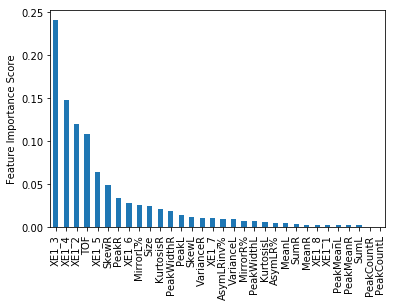

In [43]:
X = data_train.copy()
y = labels_train.replace(alt_labels)

fivefoldcrossval(X, y, plot=True)

### Hyperparameter tuning

Following the general recommendations from <a href='https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/'>here</a> for hyperparmeter tuning

#### Tuning the number of estimators

In [44]:
X = data_train.copy()
y = labels_train.replace(alt_labels)

parameters = range(20,101,10)

results = np.zeros((len(parameters), 2))

for i, n in enumerate(tqdm(parameters)):
    args = {'min_samples_split': 50, 'min_samples_leaf': 5,
            'max_depth': 7, 'max_features': 'sqrt', 
            'n_estimators': n, 'subsample': 0.8, 'learning_rate': 0.1}
    results[i] = fivefold_score(X, y, **args)

results = pd.DataFrame(results, index=parameters, columns=['mean', 'std'])

display(results.sort_values(by='mean', ascending=False).head())

100%|██████████| 9/9 [01:38<00:00, 13.59s/it]


,mean,std
80,0.9434,0.0028
100,0.9434,0.0027
90,0.9432,0.0027
70,0.9430,0.0026
60,0.9427,0.0027


* There's not much variation in the AUC scores, it's all within the standard deviations... it seems to sort of just oscillate after 70 estimators, so I'll go for 80 since it doesn't really improve after that and a lower value will hopefully speed up the rest of the tuning.

#### Tuning max_depth and min_samples_split

In [45]:
max_depths = range(3, 16, 2)
min_samples_splits = range(20, 101, 10)

parameters = [(md, mss) for md in max_depths for mss in min_samples_splits]

results = np.zeros((len(parameters),2))

for i, (md, mss) in enumerate(tqdm(parameters)):
    args = {'min_samples_split': mss, 'min_samples_leaf': 5,
            'max_depth': md, 'max_features': 'sqrt',
            'n_estimators': 80, 'subsample': 0.8, 'learning_rate': 0.1}
    results[i] = fivefold_score(X, y, **args)
    
results = pd.DataFrame(results, index=pd.MultiIndex.from_tuples(parameters, names=['max_depth', 'min_samples_split']),
                       columns=['mean', 'std'])

display(results.sort_values(by='mean', ascending=False).head())

100%|██████████| 63/63 [17:47<00:00, 24.56s/it]


mean     std
max_depth min_samples_split                
11        90                 0.9445  0.0037
          100                0.9445  0.0030
9         60                 0.9443  0.0024
11        70                 0.9443  0.0032
13        50                 0.9443  0.0034

* The combination max_depth=9, min_samples_split=60 gives a high mean AUC with the lowest standard deviation (among the high AUC values). Keeping the depth low should minimise overfitting?

#### Tuning min_samples_leaf

In [46]:
parameters = range(2,10,1)

results = np.zeros((len(parameters), 2))

for i, n in enumerate(tqdm(parameters)):
    args = {'min_samples_split': 60, 'min_samples_leaf': n,
            'max_depth': 9, 'max_features': 'sqrt',
            'n_estimators': 80, 'subsample': 0.8, 'learning_rate': 0.1}
    results[i] = fivefold_score(X, y, **args)

results = pd.DataFrame(results, index=parameters, columns=['mean', 'std'])

results.sort_values(by='mean', ascending=False)

100%|██████████| 8/8 [02:12<00:00, 16.52s/it]


,mean,std
4,0.9446,0.0025
9,0.9444,0.0031
5,0.9443,0.0024
7,0.9443,0.0031
3,0.9441,0.0035
6,0.9440,0.0034
2,0.9436,0.0031
8,0.9433,0.0030


* min_samples_leaf=4 has the highest AUC with low std. Keeping it small should also help for unbalanced samples (as we have here) ? Although a higher number might be smoother...

#### Tune max_features

In [47]:
parameters = range(5,16,2)

parameters = [3, 5, 'sqrt', 'auto', 7, 9, None]

results = np.zeros((len(parameters), 2))

for i, n in enumerate(tqdm(parameters)):
    args = {'min_samples_split': 60, 'min_samples_leaf': 4,
            'max_depth': 9, 'max_features': n,
            'n_estimators': 80, 'subsample': 0.8, 'learning_rate': 0.1}
    results[i] = fivefold_score(X, y, **args)

results = pd.DataFrame(results, index=parameters, columns=['mean', 'std'])

results.sort_values(by='mean', ascending=False)

100%|██████████| 7/7 [03:38<00:00, 37.35s/it]


,mean,std
5,0.9446,0.0025
sqrt,0.9446,0.0025
9,0.9438,0.0025
7,0.9434,0.0031
auto,0.9429,0.0040
NaN,0.9429,0.0040
3,0.9422,0.0032


* Let's go for 'sqrt' then, as that was the recommended starting point according to the instructions I'm following

#### Tune subsample

In [48]:
parameters = [0.6,0.7,0.75,0.8,0.85,0.9, 1]

results = np.zeros((len(parameters), 2))

for i, n in enumerate(tqdm(parameters)):
    args = {'min_samples_split': 60, 'min_samples_leaf': 4,
            'max_depth': 9, 'max_features': 'sqrt',
            'n_estimators': 80, 'subsample': n, 'learning_rate': 0.1}
    results[i] = fivefold_score(X, y, **args)

results = pd.DataFrame(results, index=parameters, columns=['mean', 'std'])

results.sort_values(by='mean', ascending=False)

100%|██████████| 7/7 [01:55<00:00, 17.05s/it]


,mean,std
0.80,0.9446,0.0025
0.75,0.9438,0.0038
0.85,0.9438,0.0030
0.70,0.9437,0.0029
0.90,0.9437,0.0034
1.00,0.9436,0.0031
0.60,0.9430,0.0028


#### Tuned model

In [55]:
args = {'min_samples_split': 60, 'min_samples_leaf': 4,
            'max_depth': 9, 'max_features': 'sqrt',
            'n_estimators': 80, 'subsample': 0.8, 'learning_rate': 0.1}

model = GradientBoostingClassifier(random_state=0, **args)

5it [00:16,  3.40s/it]

Average performance metrics:
Accuracy:  83.71 %
Balanced accuracy:  83.59 %
Precision: 


bacteria    0.879008
fungal      0.542529
non-bio     0.937568
pollen      0.651515
dtype: float64

AUC:  0.9445730281123896
Confusion matrix (sum):


,bacteria,fungal,non-bio,pollen
bacteria,2303,18,97,24
fungal,10,708,159,105
non-bio,300,522,4280,216
pollen,7,57,29,645


Feature importances:


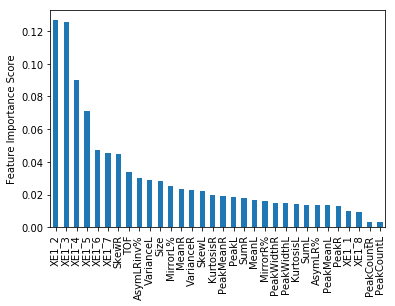

In [56]:
X = data_train.copy()
y = labels_train.replace(alt_labels)

fivefoldcrossval(X, y, plot=True, **args)

* The accuracy and AUC have improved slightly
* The feature importance is much more balanced. This is probably a good thing, since it means the model can utilise more of the available information?